In [1]:
import scipy.optimize as opt
import numpy as np
# from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib as mpl


tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    'text.latex.preamble':r"\usepackage{amsmath}"
}

plt.rcParams.update(tex_fonts)

plotargs = {
    "vmin": -np.pi,
    "vmax": np.pi,
    "cmap": 'twilight'
}

In [2]:
def unique_permutations(elements):
    if len(elements) == 1:
        yield (elements[0],)
    else:
        unique_elements = set(elements)
        for first_element in unique_elements:
            remaining_elements = list(elements)
            remaining_elements.remove(first_element)
            for sub_permutation in unique_permutations(remaining_elements):
                yield (first_element,) + sub_permutation


In [3]:

region = opt.LinearConstraint(np.eye(4), lb=-np.pi*np.ones(4),ub=(np.pi+0.1)*np.ones(4) )
modulo = opt.NonlinearConstraint(lambda b : np.cos(np.sum(b)), 1,1)

def energy_cost(b, gvec):
    return np.dot(gvec, np.cos(b))

def energy_der(b, gvec):
    return gvec* -np.sin(b)

def energy_hess(b, gvec):
    return -np.diag(gvec* np.cos(b))

Ansätze = [np.zeros(4),np.pi*np.ones(4), np.pi/2*np.ones(4), -np.pi/2*np.ones(4)]
Ansätze += list(unique_permutations([0,0, np.pi, np.pi]))

def best_flux(gvec):
    best_fun = np.sum(np.abs(gvec))
    res = None

    for ansatz in Ansätze:
        r = opt.minimize(energy_cost, ansatz, args=gvec,
                       method='trust-constr',
                       constraints = [region, modulo],
                       jac = energy_der,
                       hess= energy_hess
                       )
        if r['fun'] < best_fun:
            best_fun = r['fun']
            res = r

        
    return res

In [4]:
def best_flux_fast(gvec, guess = [0,0,0,0]):
    best_fun = np.sum(np.abs(gvec)) +1
    res = None

    for s in [-2*np.pi, 0, 2*np.pi, 4*np.pi]:
        vison = opt.LinearConstraint(np.ones(4), s,s)
        r = opt.minimize(energy_cost, guess, args=gvec,
                       method='trust-constr',
                       constraints = [region, vison],
                       jac = energy_der,
                       hess= energy_hess
                       )
        if r['fun'] < best_fun:
            best_fun = r['fun']
            res = r

        
    return res

# def best_flux_extra_fast(gvec):


# 110 magnetic field. 

$$ J_{\rm ring}^{(ijk)} =  \frac{3 J_\pm^3}{2J_y^2}, \quad (ijk) = (230),(301)  $$
$$ J_{\rm ring}^{(ijk)} = \frac{3 J_\pm^3}{2J_y^2} - \frac{5 B^2 J_\pm^2}{6J_y^3}, \quad (ijk) = (012),(123) $$


$$ \sum J_{ring} \cos( \Phi) $$

In [5]:
# Work in units where Jy = 1
# third order result - only valid if $Jpm/Jy << 0.1$.
def J_110_ijk(B, jpm):
    g01 =  3/2 * jpm**3
    g23 =  3/2 * jpm**3 - 5/6 * B**2*jpm**2
    return [g01, g01, g23, g23]


jpm_grid = np.linspace(-0.1,0.1,100)
b_grid = np.linspace(0,0.3,100)


In [6]:

# Last index: (012), (123), (230), (301)
flux_110 = np.zeros((4, jpm_grid.shape[0], b_grid.shape[0]))

for i, jpm in enumerate(jpm_grid):
    for j, b in enumerate(b_grid):
        r = best_flux_fast(J_110_ijk(b, jpm))
        flux_110[:, i,j] = r['x']
        # flux_110_230[i,j] = r['x'][2]



Text(0.5, 1.0, '$\\Phi_{(012)} = \\Phi_{(123)}$')

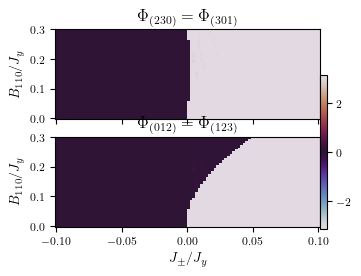

In [7]:
aspect = 3/4

fs= (3.42, 3.42*aspect)


fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True, figsize = fs)

c = ax1.pcolormesh(jpm_grid, b_grid, flux_110[0, :,:].T, **plotargs)
c = ax2.pcolormesh(jpm_grid, b_grid, flux_110[2, :,:].T, **plotargs)

cax = fig.add_axes([0.9,0.1,0.02,0.6])
fig.colorbar(c, cax=cax)

ax2.set_xlabel(r"$J_\pm/J_y$")
ax2.set_ylabel(r"$B_{110}/J_y$")
ax1.set_ylabel(r"$B_{110}/J_y$")

ax1.set_title(r"$\Phi_{(230)} = \Phi_{(301)}$")
ax2.set_title(r"$\Phi_{(012)} = \Phi_{(123)}$")

# 111 magnetic field

$$J_{\rm ring}^{(ijk)} = \frac{3 J_\pm^2}{2J_y^2} - \frac{5 B^2 J_\pm^2}{36J_y^3}, \quad (ijk) = (012),(301),(230) $$
$$J_{\rm ring}^{(ijk)} = \frac{3 J_\pm^2}{2J_y^2} -\frac{5 B^2 J_\pm^2}{4J_y^3}, \quad (ijk) = (123)$$


In [8]:
# Work in units where Jy = 1
# third order result - only valid if $Jpm/Jy << 0.1$.
def J_111_ijk(B, jpm):
    g123 = 3/2 * jpm**3 - 5/36 * B**2*jpm**2
    g0 =  3/2 * jpm**3 - 5/4 * B**2*jpm**2
    return [g0, g123, g123, g123]


In [9]:

flux_111 = np.zeros((4, jpm_grid.shape[0], b_grid.shape[0]))
# flux_111_123 = np.zeros((jpm_grid.shape[0], b_grid.shape[0]))

for i, jpm in enumerate(jpm_grid):
    for j, b in enumerate(b_grid):
        r = best_flux_fast(J_111_ijk(b, jpm), guess=[np.pi, np.pi/3,np.pi/3,np.pi/3])
        flux_111[:, i,j] = r['x']


In [10]:

def J_100_ijk(B, jpm):
    g0 =  3/2 * jpm**3 - 5/12 * B**2*jpm**2
    return [g0, g0, g0, g0]

flux_100 = np.zeros((4, jpm_grid.shape[0], b_grid.shape[0]))
# flux_111_123 = np.zeros((jpm_grid.shape[0], b_grid.shape[0]))

for i, jpm in enumerate(jpm_grid):
    for j, b in enumerate(b_grid):
        flux_100[:, i,j] = np.zeros(4) if J_100_ijk(b, jpm)[0] < 0 else np.pi*np.ones(4) 


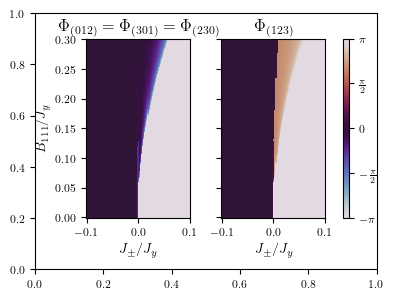

In [11]:
aspect = 3/4

fs= (3.42, 3.42*aspect)

fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=fs)

c = ax1.pcolormesh(jpm_grid, b_grid,- np.abs(flux_111[0]).T, **plotargs)
c = ax2.pcolormesh(jpm_grid, b_grid, np.abs(flux_111[1]).T, **plotargs)

cax = fig.add_axes([0.9,0.2,0.02,0.7])
fig.subplots_adjust(left=0.15, right=0.85, wspace=0.3,bottom=0.2,top=0.9)
cb = fig.colorbar(c, cax=cax)
cb.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2,np.pi])
cb.set_ticklabels([f"${x}$" for x in r"-\pi -\frac{\pi}{2} 0 \frac{\pi}{2} \pi".split()] )

ax1.set_xlabel(r"$J_\pm/J_y$")
ax2.set_xlabel(r"$J_\pm/J_y$")
# ax2.set_ylabel(r"$B_{111}/J_y$")
ax1.set_ylabel(r"$B_{111}/J_y$")

ax1.set_title(r"$\Phi_{(012)} = \Phi_{(301)} = \Phi_{(230)}$")
ax2.set_title(r"$\Phi_{(123)}$")

fig.add_axes([0,0,1,1]).patch.set_alpha(0)


In [12]:
from matplotlib.colors import ListedColormap
pi3 = np.pi/3

phases = [
     {
        'name': r"$U(1)_0$",
        'cond': lambda r : np.all(np.isclose(np.cos(r), np.ones(4),1e-3), axis=-1),
        'color': "#EDF2EF",
    },
    {
        'name': r"$U(1)_\pi$",
        'cond': lambda r : np.all(np.isclose(np.cos(r), -1*np.ones(4),1e-3),axis=-1),
        'color': "#593a6d", # "#212738",
    },
    {
        'name': r"$\pi\pi00$",
        'cond': lambda r : np.isclose(np.sum(np.cos(r), axis=-1), 0, 1e-1) ,
        'color': "#57C4E5",
    },
    {
        'name': r"FF",
        'cond': lambda r : np.logical_not(phases[0]['cond'](r) | phases[1]['cond'](r) | phases[2]['cond'](r)),
        'color': "#F97068",
    }
]

# takes in numeric data [data] 
def plot_phases(ax, X, Y, data, phasedict: dict, pcolormesh_kwargs = {}, exclude_0_tol=1e-4):
    for phase in phasedict:
        phase["selection"] = phase['cond'](data)
        Z = np.meshgrid(X, Y)

        mask = np.abs(Z[0]) < exclude_0_tol
        
        ax.pcolormesh(X, Y, np.ma.masked_where(mask, phase['selection'].T), 
                      cmap=ListedColormap([[0,0,0,0], phase['color']], name=phase['name'])
                      , **pcolormesh_kwargs)
        



In [41]:
###################################################
# the phase dia


def figlabel(ax, text:str, **kwargs):
    ax.text(0.05, 0.03, text, transform=ax.transAxes, horizontalalignment='left',verticalalignment='bottom', **kwargs)

def make_phaseplots(a1, a2, a3):
    pcm_args = {"rasterized": True}
    
    plot_phases(a1, jpm_grid, b_grid, np.moveaxis(flux_111, 0,-1), phases, pcm_args, exclude_0_tol=3e-3  )
    plot_phases(a2, jpm_grid, b_grid, np.moveaxis(flux_110, 0,-1), phases, pcm_args )
    plot_phases(a3, jpm_grid, b_grid, np.moveaxis(flux_100, 0,-1), phases, pcm_args)


    algn = {"horizontalalignment": "center", "verticalalignment": "center"}
    arrowprops = dict( arrowstyle = "->", color='k') 

    a1.text(-0.05, 0.1, r"$U(1)_0$",color='k' , **algn)
    a1.annotate("FF", xy = (0.03, 0.25), xytext=(-0.08,0.15),color='k', arrowprops=arrowprops)
    a1.text(0.05, 0.1, r"$U(1)_\pi$",color='w', **algn)

    a2.text(-0.05, 0.1, "$U(1)_0$",      color='k', **algn)
    a2.annotate(r"$\pi \pi 0 0 $", xy = (0.03, 0.25), xytext=(-0.1,0.15),color='k', arrowprops=arrowprops)
    a2.text(0.05, 0.1, r"$U(1)_\pi$",     color='w', **algn)

    a3.text(-0.05, 0.1, r"$U(1)_0$",      color='k', **algn)
    a3.text(0.05, 0.1, r"$U(1)_\pi$",     color='w', **algn)



def plot_jring(col_111, col_110, col_100, jpm, bvals):
    pcolormesh_args = dict(
        cmap= mpl.cm.RdYlBu_r,
        norm = mpl.colors.SymLogNorm(vmin=-1e-3,vmax=1e-3,linthresh=1e-6),
        rasterized=True
    )
    
    s = col_111[0].pcolormesh(jpm,bvals,J_111_ijk(bvals, jpm)[0], **pcolormesh_args)
    figlabel(col_111[0], r'$g_{0}$', color='white')
    s = col_111[1].pcolormesh(jpm,bvals,J_111_ijk(bvals, jpm)[1], **pcolormesh_args)
    figlabel(col_111[1], r'$g_{1,2,3}$', color='white')

    s = col_110[0].pcolormesh(jpm,bvals,J_110_ijk(bvals, jpm)[0], **pcolormesh_args)
    figlabel(col_110[0], r'$g_{0,2}$', color='white')
    s = col_110[1].pcolormesh(jpm,bvals,J_110_ijk(bvals, jpm)[2], **pcolormesh_args)
    figlabel(col_110[1], r'$g_{1, 3}$', color='white')

    col_100[0].pcolormesh(jpm,bvals,J_100_ijk(bvals, jpm)[0], **pcolormesh_args)
    figlabel(col_100[0], r'$g_{p}$', color='white')
    return s
    
def label_axes(Ax):
    # General axis labels
    # Ax[-1][0].set_xlabel('$J_{\pm}/J_{y}$')
    # Ax[-1][1].set_xlabel('$J_{\pm}/J_{y}$')
    # Ax[1][2].set_xlabel('$J_{\pm}/J_{y}$')

    for row in Ax:
        a = row[-1] # rightmost
        a.set_ylabel('$B/J_{y}$')
        a.yaxis.set_label_position("right")
        a.yaxis.tick_right()
        a.yaxis.set_tick_params(which='major', labelleft=False, labelright=True)

    
        for a in (row[0], row[1]):
            # a.set_ylabel('$B/J_{y}$')
            a.yaxis.set_tick_params(which='major', labelleft=False, labelright=False)
            ml = mpl.ticker.MultipleLocator(0.05)
            a.yaxis.set_minor_locator(ml)
            a.yaxis.tick_right()
            a.yaxis.set_label_position("right")

    Ax[0][2].set_title(r'$B \| [111]$')
    Ax[0][1].set_title(r'$B \| [110]$')
    Ax[0][0].set_title(r'$B \| [100]$')


plot_analytic_bounds = {
    "100": lambda ax, b : (ax.plot( ( 2*5/3/12 ) * b**2, b, 'k-'),),
    "110": lambda ax, b : (ax.plot( 5 * b**2 / 9, b, 'k-'), ax.plot(0*b, b, '-', color='k')),
    "111": lambda ax, b : (ax.plot( ( 35/54 ) * b**2, b, 'k-'), ax.plot( ( 5/54 ) * b**2, b, 'k-'))
}



In [46]:
text_args = dict(
    horizontalalignment= 'left',
    verticalalignment = 'top',
)

pcm_args = {"rasterized": True}

def make_plots_phases_1x3(Ax, jpm_grid, b_grid):


    jpm, bvals = np.meshgrid(jpm_grid, b_grid)
    # plt.contour(jpm,bvals,J_100_ijk(bvals, jpm)[0], levels=101)

    make_phaseplots(Ax[0][2],Ax[0][1],Ax[0][0])

    label_axes(Ax)

    for (a, l) in zip(Ax[0], ["100","110","111"]):
        plot_analytic_bounds[l](a, b_grid)
    
    for j, a in enumerate([ Ax[0][0], Ax[0][1], Ax[0][2] ]):
        m = text_args.copy()
        if j < 3:
            m['color'] = 'k'
        a.text(0.05, 0.95, 
               chr(ord('a') + j) + ')'
               , transform=a.transAxes, **m)
        
    
    for row in Ax:
        for a in row:
            a.set_xticks([-0.1,-0.05,0,0.05,0.1])
            a.set_xticklabels([])

    xl = [-0.1, '', 0, '', 0.1]
    for a in Ax[0]:
        a.set_xticklabels(xl,rotation=45)
        a.text(0.5,-0.3,r'$J_{\pm}/J_{y}$', transform=a.transAxes, horizontalalignment='center',verticalalignment='top')




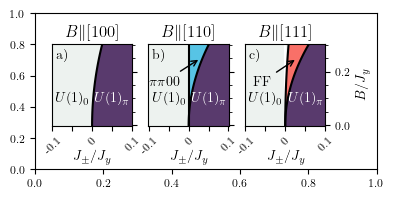

In [103]:
fs= (3.42, 1.42*1.1)

fig, Ax = plt.subplots(1,3, squeeze=False, figsize=fs, sharex=False, sharey=True)
make_plots_phases_1x3(Ax, jpm_grid, b_grid)

settings_1x3 = dict(
top = 0.8,
bottom = 0.28,
hspace = 0.12,
left = 0.05,
right = 0.85,
)

fig.subplots_adjust(**settings_1x3)
fig.savefig("/Users/alaricsanders/Documents/gh-papers/Experimentally-Tunable-QED-in-DO-QSI/FIG/flux_phase_diagram_combined_1x3.pdf",dpi=300,format='pdf')
# fig.savefig("/Users/alaricsanders/Desktop/figure_out/fig1x3.pdf",dpi=300,format='pdf')

fig.add_axes([0,0,1,1]).patch.set_alpha(0)

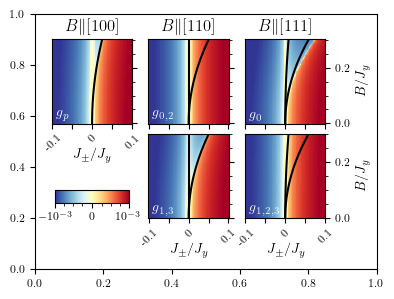

In [108]:
def make_Jringplot_2x3(Ax, jpm_grid, b_grid):
    jpm, bvals = np.meshgrid(jpm_grid, b_grid)
    s = plot_jring(
        [Ax[0][2], Ax[1][2]],
        [Ax[0][1], Ax[1][1]],
        [Ax[0][0], Ax[1][0]],
        jpm, bvals
        )
    for (a, l) in zip([Ax[0][0], Ax[0][1], Ax[1][1], Ax[0][2],Ax[1][2]],
                      ["100",  "110", "110", "111", "111"]):
        plot_analytic_bounds[l](a, b_grid)

    Ax[1][0].axis('off')
    for row in Ax:
        for a in row:
            a.set_xticks([-0.1,-0.05,0,0.05,0.1])
            a.set_xticklabels([])
    
    xl = [-0.1, '', 0, '', 0.1]
    for a in [Ax[0][0], Ax[1][1], Ax[1][2]]:
        a.set_xticks([-0.1,-0.05,0,0.05,0.1])
        a.set_xticklabels(xl,rotation=45)
        a.text(0.5,-0.3,r'$J_{\pm}/J_{y}$', transform=a.transAxes, horizontalalignment='center',verticalalignment='top')

    label_axes(Ax)
    
    return s

settings_2x3 = dict(
    top = 0.9,
    bottom = 0.2,
    hspace = 0.12,
    left = 0.05,
    right = 0.85
)

fs= (3.42, 1.42*1.8)

fig, Ax = plt.subplots(2,3, squeeze=False, figsize=fs, sharex=False, sharey=True)

s = make_Jringplot_2x3(Ax, jpm_grid, b_grid)

fig.subplots_adjust(**settings_2x3)
delta = 0.01
cax = fig.add_axes([settings_2x3["left"]+delta, 0.26, 0.235-2*delta, 0.05])
fig.colorbar(s, cax=cax, orientation='horizontal')
cax.set_xticks([-1e-3,0,1e-3])

fig.savefig("/Users/alaricsanders/Documents/gh-papers/Experimentally-Tunable-QED-in-DO-QSI/FIG/g_diagram_2x3.pdf",dpi=300,format='pdf')
fig.add_axes([0,0,1,1]).patch.set_alpha(0)

In [96]:
cax.get_xticks()

array([-1.e+00, -1.e-01, -1.e-02, -1.e-03, -1.e-04, -1.e-05, -1.e-06,
        0.e+00,  1.e-06,  1.e-05,  1.e-04,  1.e-03,  1.e-02,  1.e-01,
        1.e+00])

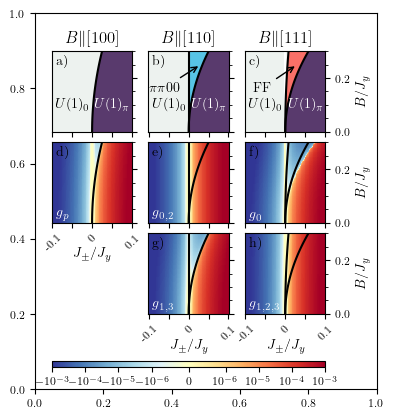

In [42]:
def make_plots_3x3(jpm_grid, b_grid):
    fs= (3.42, 3.42*1.1)


    jpm, bvals = np.meshgrid(jpm_grid, b_grid)
    # plt.contour(jpm,bvals,J_100_ijk(bvals, jpm)[0], levels=101)
    fig, Ax = plt.subplots(3,3, figsize=fs, sharex=False, sharey=True)

    make_phaseplots(Ax[0][2],Ax[0][1],Ax[0][0])

    label_axes(Ax)

    s = plot_jring(
        [Ax[1][2],Ax[2][2]],
        [Ax[1][1], Ax[2][1]],
        [Ax[1][0], Ax[2][0]],
        jpm, bvals
        )

    # Ax[0][0].plot([0,0],[b_grid[0],b_grid[-1]],"k:")
    # Ax[0][1].plot([0,0],[b_grid[0],b_grid[-1]],"k:")
    
    top = 0.9
    bottom = 0.2
    hspace = 0.12

    left = 0.05
    right = 0.85

    # panelh = (top-bottom-hspace)/3

    fig.subplots_adjust(left=left, right=right, bottom=bottom, top=top, hspace=hspace,)
    cax = fig.add_axes([left, 0.06, right-left, 0.015])
    fig.colorbar(s, cax=cax, orientation='horizontal')

    for a in [Ax[0][0],Ax[1][0]]:
        plot_analytic_bounds["100"](a, b_grid)

    for a in [Ax[0][1],Ax[1][1],Ax[2][1]]:
        plot_analytic_bounds["110"](a, b_grid)

    for a in [Ax[0][2],Ax[1][2],Ax[2][2]]:
        plot_analytic_bounds["111"](a, b_grid)

    

    
    for j, a in enumerate([Ax[0][0], Ax[0][1], Ax[0][2],
                           Ax[1][0], Ax[1][1], Ax[1][2],
                           Ax[2][1],Ax[2][2]]):
        m = text_args.copy()
        if j < 3:
            m['color'] = 'k'
        a.text(0.05, 0.95, 
               chr(ord('a') + j) + ')'
               , transform=a.transAxes, **m)
        
    Ax[2][0].axis('off')
    for row in Ax:
        for a in row:
            a.set_xticks([-0.1,-0.05,0,0.05,0.1])
            a.set_xticklabels([])

    xl = [-0.1, '', 0, '', 0.1]
    for a in [Ax[1][0], Ax[2][1], Ax[2][2]]:
        a.set_xticklabels(xl,rotation=45)
        a.text(0.5,-0.3,r'$J_{\pm}/J_{y}$', transform=a.transAxes, horizontalalignment='center',verticalalignment='top')

    # fig.savefig("/Users/alaricsanders/Documents/gh-papers/Experimentally-Tunable-QED-in-DO-QSI/FIG/flux_phase_diagram_combined_3x3.pdf",dpi=300,format='pdf')
    fig.savefig("/Users/alaricsanders/Desktop/figure_out/fig3x3.pdf",dpi=300,format='pdf')

    fig.add_axes([0,0,1,1]).patch.set_alpha(0)


make_plots_3x3(jpm_grid, b_grid)

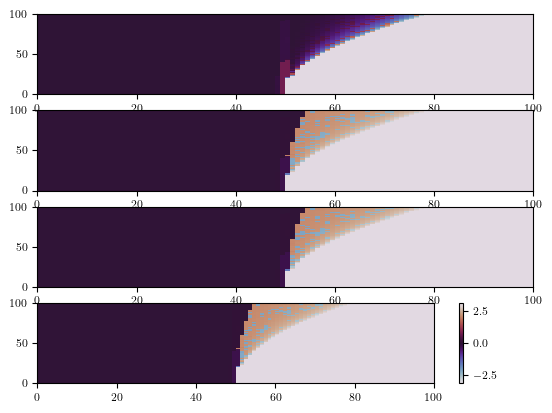

In [29]:
fix, Ax = plt.subplots(4)
for j, a in enumerate(Ax):
    c = a.pcolormesh(flux_111[j].T, **plotargs)


plt.colorbar(c)


/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_14188/3515689031.py:5: RuntimeWarning: invalid value encountered in arccos
  plt.plot(jpm_grid, np.pi/2-1.5*np.arccos( chi / 2 ), 'k:')
/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_14188/3515689031.py:6: RuntimeWarning: invalid value encountered in arccos
  plt.plot(jpm_grid, -np.pi/2+1.5*np.arccos( chi / 2 ), 'k:')
/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_14188/3515689031.py:9: RuntimeWarning: invalid value encountered in arccos
  plt.plot(jpm_grid, np.pi/2+0.5*np.arccos( chi / 2 ), 'r:')
/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_14188/3515689031.py:10: RuntimeWarning: invalid value encountered in arccos
  plt.plot(jpm_grid, -np.pi/2-0.5*np.arccos( chi / 2 ), 'r:')


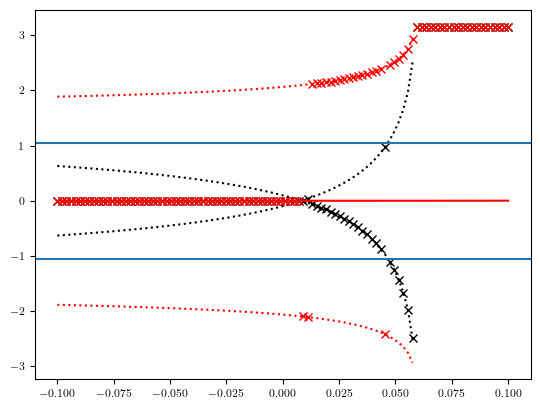

In [30]:

g = J_111_ijk(b_grid[-1], jpm_grid)
chi = g[1]/g[0] + 1

plt.plot(jpm_grid, flux_111[0,:,-1], 'kx')
plt.plot(jpm_grid, np.pi/2-1.5*np.arccos( chi / 2 ), 'k:')
plt.plot(jpm_grid, -np.pi/2+1.5*np.arccos( chi / 2 ), 'k:')

plt.plot(jpm_grid, flux_111[1,:,-1], 'rx')
plt.plot(jpm_grid, np.pi/2+0.5*np.arccos( chi / 2 ), 'r:')
plt.plot(jpm_grid, -np.pi/2-0.5*np.arccos( chi / 2 ), 'r:')

plt.plot(jpm_grid, g[1], 'r-')

plt.axhline(np.pi/3)
plt.axhline(-np.pi/3)

def FF_fluxes(B, jpm):
    g = J_111_ijk(b_grid[-1], jpm_grid)
    chi = g[1]/g[0] + 1
    b0 = np.pi/2-1.5*np.arccos( chi / 2 )
    b1 = np.pi/2+0.5*np.arccos( chi / 2 )
    return np.array([b0, b1, b1, b1])



In [40]:
import matplotlib as mpl

def J_100_ijk(B, jpm):
    g =  3/2 * (jpm**3) - 5/12 * B**2*(jpm**2)
    # g = jpm + B
    return [g, g, g, g]

